<a href="https://colab.research.google.com/github/aknakshay/NLP_Sentiment_Classification_IMDB_Reviews/blob/master/Sentiment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
  The task is to classify the sentiment of the text

  Text is first cleaned by removing html tags, limited stopwords,
  and performing case normalisation

  The data is further filtered by restricting the
  vocabulary size

  Data is then encoded into numbers and padded to have the same
  length

  A Bidirectional GRU model is trained over data with tanh activation

  In two epochs only, model fits the data and gives an accuracy of
  around 87%


'''

'\n  The task is to classify the sentiment of the text\n\n  Text is first cleaned by removing html tags, limited stopwords,\n  and performing case normalisation\n\n  The data is further filtered by restricting the\n  vocabulary size\n\n  Data is then encoded into numbers and padded to have the same\n  length\n\n  A Bidirectional GRU model is trained over data with tanh activation\n\n  In two epochs only, model fits the data and gives an accuracy of\n  around 87%\n\n\n'

In [2]:
import os
from collections import Counter
from tqdm import tqdm_notebook
import re 
import nltk
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
import random
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, GRU, Dropout, Bidirectional

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
'''
Data Loading part taken from 
https://bsantraigi.github.io/2019/07/13/text-classification-using-naive-bayes-method.html
'''
class Lang:

    def __init__(self, counter, vocab_size):
        '''
        Creates instance of Lang
        '''
        self.word2id = {}
        self.id2word = {}
        self.pad = "<PAD>"
        self.sos = "<SOS>"
        self.eos = "<EOS>"
        self.unk = "<UNK>"
        
        self.ipad = 0
        self.isos = 1
        self.ieos = 2
        self.iunk = 3
        
        self.word2id[self.pad] = 0
        self.word2id[self.sos] = 1
        self.word2id[self.eos] = 2
        self.word2id[self.unk] = 3
        
        self.id2word[0] = self.pad
        self.id2word[1] = self.sos
        self.id2word[2] = self.eos
        self.id2word[3] = self.unk
        
        curr_id = 4
        # Filtering the vocab to keeping only most common words
        # Also defining an encoder and decoder for the words
        for w, c in counter.most_common(vocab_size-curr_id):
            self.word2id[w] = curr_id
            self.id2word[curr_id] = w
            curr_id += 1
    
    def encodeSentence(self, wseq, max_len=-1):
        if max_len == -1:
            return [self.word2id[w] if w in self.word2id else self.iunk for w in wseq]
        else:
            return ([self.word2id[w] if w in self.word2id else self.iunk for w in wseq] + [self.ieos] + [self.ipad]*max_len)[:max_len]
        
    def encodeSentence2(self, wseq, max_len=-1):
        return min(max_len, len(wseq)+1), \
            ([self.word2id[w] if w in self.word2id else self.iunk for w in wseq] + \
                [self.ieos] + [self.ipad]*max_len)[:max_len]
    
    def decodeSentence(self, id_seq):
        id_seq = np.array(id_seq + [self.ieos])
        j = np.argmax(id_seq==self.ieos)
        s = ' '.join([self.id2word[x] for x in id_seq[:j]])
        s = s.replace(self.unk, "UNK")
        return s

In [4]:
# Downloads and untar's the data
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
![ ! -d data ] && mkdir data/
![ ! -d data/aclImdb/ ] && tar -xzf aclImdb_v1.tar.gz -C data/

--2019-11-07 18:33:28--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.2’

aclImdb_v1.tar.gz.2 100%[===================>]  80.23M   895KB/s    in 75s     

2019-11-07 18:34:43 (1.07 MB/s) - ‘aclImdb_v1.tar.gz.2’ saved [84125825/84125825]



In [0]:
# Appending Positive & Negative examples for train in train_positive and train_negative
data_folder = 'data/aclImdb/'
rp = os.path.join(data_folder, 'train/pos')
train_positive = [os.path.join(rp, f) for f in os.listdir(rp)]
rp = os.path.join(data_folder, 'train/neg')
train_negative = [os.path.join(rp, f) for f in os.listdir(rp)]

# Appending Positive & Negative examples for test in test_positive and test_negative
rp = os.path.join(data_folder, 'test/pos')
test_positive = [os.path.join(rp, f) for f in os.listdir(rp)]
rp = os.path.join(data_folder, 'test/neg')
test_negative = [os.path.join(rp, f) for f in os.listdir(rp)]

In [0]:
'''
  Editing the stopword list to remove the words that have impact on sentiment classification
'''
stopword_set = set(stopwords.words("english"))
remove_list = ["couldn't","isn","don't","against","doesn","few","wouldn't","very","haven't","needn't","hasn't","wasn","hadn't","isn't","shouldn",\
                   "wouldn","won't","more","didn't","most","mightn't","didn","shouldn't","wasn't","doesn't","mustn't","don","aren't","weren't","not","should've"]
for word in remove_list:
        stopword_set.remove(word)

In [7]:
re_html_cleaner = re.compile(r"<.*?>")

en_counter = Counter()
train_data = []
for _fname in tqdm_notebook(train_positive, desc="Crunching +ve samples: "):
    with open(_fname) as f:
        text = f.read().strip()
        # Cleaning html links
        text = re_html_cleaner.sub(" ", text)
        # Cleaning special characters and punctuations
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        # Tokenizing the words
        wseq = nltk.tokenize.word_tokenize(text.lower())
        # Filtering out the stopwords
        wseq = [x for x in wseq if x not in stopword_set]
        # Adding words to counter for vocab
        en_counter += Counter(wseq)
        train_data.append((wseq, 1,_fname))
        
for _fname in tqdm_notebook(train_negative, desc="Crunching -ve samples: "):
    with open(_fname) as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        wseq = nltk.tokenize.word_tokenize(text.lower())
        wseq = [x for x in wseq if x not in stopword_set]
        en_counter += Counter(wseq)
        train_data.append((wseq, 0,_fname))
        
        
test_data = []
for _fname in tqdm_notebook(test_positive, desc="Crunching +ve samples: "):
    with open(_fname) as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        wseq = nltk.tokenize.word_tokenize(text.lower())
        wseq = [x for x in wseq if x not in stopword_set]
        test_data.append((wseq, 1,_fname))
        
for _fname in tqdm_notebook(test_negative, desc="Crunching -ve samples: "):
    with open(_fname) as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        wseq = nltk.tokenize.word_tokenize(text.lower())
        wseq = [x for x in wseq if x not in stopword_set]
        test_data.append((wseq, 0,_fname))

In [0]:
#Shuffling the train_data and test_data to mix positive and negative sentiment data
random.seed(0)
random.shuffle(train_data)
random.shuffle(test_data)

In [0]:
# Creating Lang class object with a vocab of 10000 words
V = 10000
en_lang = Lang(en_counter, V)

In [0]:
# Encoding the sentences
train_X_encoded = [en_lang.encodeSentence2(text[0])[1] for text in train_data]
train_Y_encoded = [x[1] for x in train_data]
test_X_encoded = [en_lang.encodeSentence2(text[0])[1] for text in test_data ]
test_Y_encoded = [x[1] for x in test_data]

In [0]:
# Padding the sequences
max_review_length = 500
X_train = pad_sequences(train_X_encoded,maxlen=max_review_length)
X_test = pad_sequences(test_X_encoded,maxlen=max_review_length)

In [12]:
# BiDirectional Deep Learning Model

embedding = 500
model = Sequential()
model.add(Embedding(5000,embedding,input_length=max_review_length))
model.add(Dropout(0.3))
model.add(Bidirectional(GRU(128, activation='tanh', recurrent_activation='hard_sigmoid')))

model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
history = model.fit(X_train,train_Y_encoded,epochs=2,batch_size=256,validation_data=(X_test,test_Y_encoded))




Train on 25000 samples, validate on 25000 samples
Epoch 1/2





25000/25000 [==============================] - 136s 5ms/step - loss: 0.4405 - acc: 0.7760 - val_loss: 0.3327 - val_acc: 0.8599
Epoch 2/2
25000/25000 [==============================] - 135s 5ms/step - loss: 0.2561 - acc: 0.8986 - val_loss: 0.2995 - val_acc: 0.8754


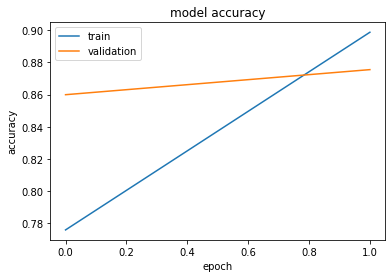

In [14]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

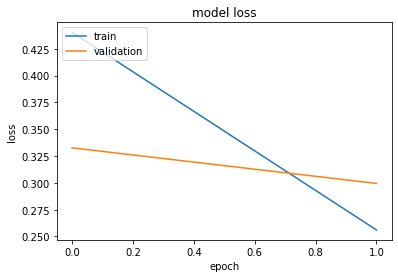

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()